# Measuring uncertainty in probability predictions using bagging

With bagging('boostrap aggregation') we train multiple models based on multiple bootstrap samples (sampling with replacement) of the training data.

Here we use bagging to examine variation in predicted probability of survival.

For an introduction to bootstrapping see: https://youtu.be/Xz0x-8-cgaQ

## Import packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

## Download data if required

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Load data and split into trainign and test sets

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

# Shuffle data
data = data.sample(frac=1, random_state=42)

# Split into training and test sets
training_size = int(len(data) * 0.75)
train = data.iloc[0: training_size]
test = data.iloc[training_size:]

## Create bootstrap sampled training sets

In [4]:
splits = 30
train_set = []
for i in range(splits):
    train_set.append(train.sample(frac=1, replace=True))

## Train models

In [5]:
# Set up lists for models and probability predictions
models = []
results  = []
accuracies = []

for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Survived', axis=1)
    X_test = test.drop('Survived', axis=1)
    y_train = train_set[i]['Survived']
    y_test = test['Survived']

    # Define and train model; use different random seed for each model
    model = XGBClassifier(verbosity=0, seed=42+i)
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5
    results.append([y_probs])

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

results = np.array(results)
results = results.T.reshape(-1, splits)

In [6]:
print (f'Mean accuracy: {np.mean(accuracies):0.3f}')

Mean accuracy: 0.799


Show boxplot of accuracy measurements.

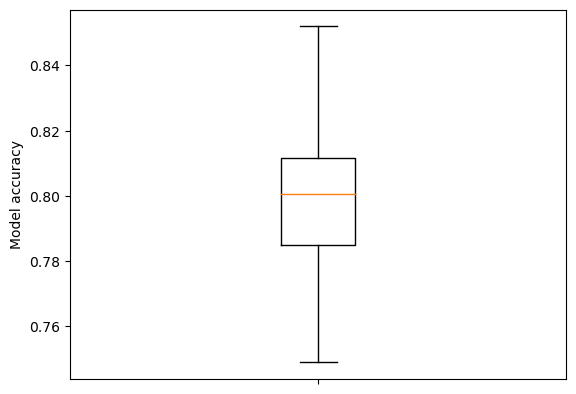

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
ax.boxplot(accuracies, whis=999)
ax.set_ylabel('Model accuracy')
ax.axes.xaxis.set_ticklabels([]) # Remove xtick labels
plt.show()

## Measure accuracy of consensus decision

Consensus decision is the majority vote of the models.

In [8]:
classification = results >= 0.5
consensus = classification.sum(axis=1) >= splits/2
consensus_accuracy = np.mean(consensus == y_test)
print (f'Consensus accuracy: {consensus_accuracy:0.3f}')

Consensus accuracy: 0.821


## Plot variation in probability prediction

In [9]:
# Sort by mean survival
results = results[np.median(results,axis=1).argsort()]

### Box plot

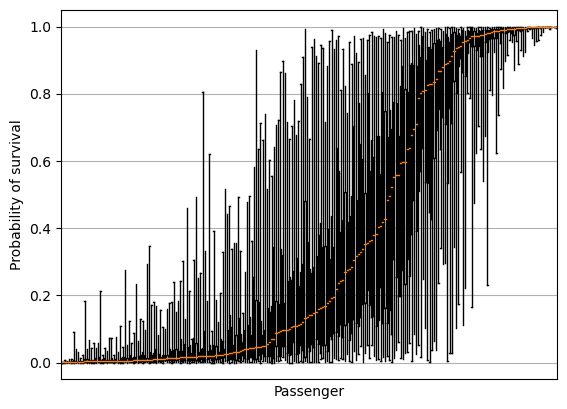

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.boxplot(results.T, whis=999)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
plt.show()

### Plot of standard deviation

In [11]:
# Sort by mean survival
results = results[np.mean(results,axis=1).argsort()]

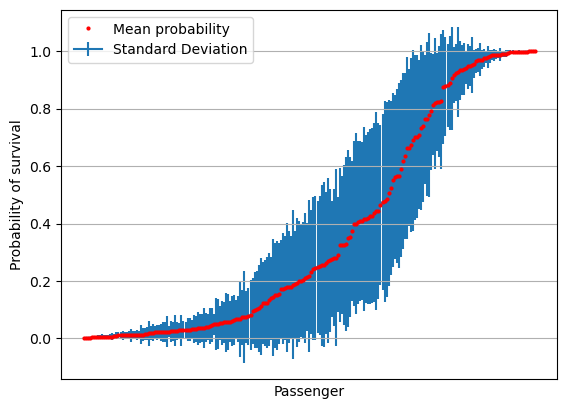

In [12]:
results = results[np.mean(results,axis=1).argsort()]
mean = np.mean(results,axis=1)
stdev = np.std(results,axis=1)

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=stdev, label='Standard Deviation', zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()

### Plot of standard error

In [13]:
# Sort by mean survival
results = results[np.mean(results,axis=1).argsort()]

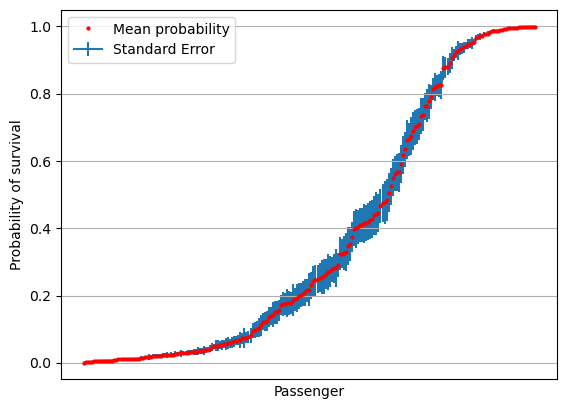

In [14]:
results = results[np.mean(results,axis=1).argsort()]
mean = np.mean(results,axis=1)
stdev = np.std(results,axis=1)
se = stdev / np.sqrt(splits)

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=se, label='Standard Error', zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()

### Plot confidence limits

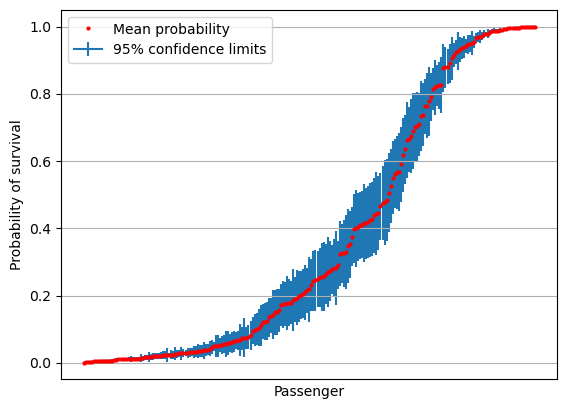

In [15]:
import scipy.stats as st

# create 95% confidence interval
confidence = st.t.interval(alpha=0.95, df=len(results)-1, loc=mean, scale=se)
confidence_magnitude = confidence[1] - confidence[0]

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=(confidence_magnitude/2), 
    label='95% confidence limits' ,zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()

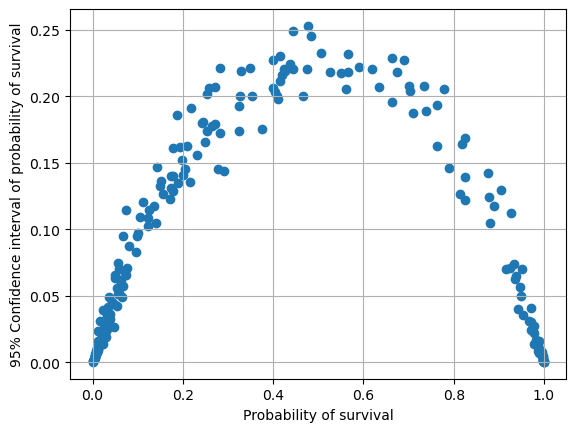

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mean, confidence_magnitude)
ax.set_xlabel('Probability of survival')
ax.set_ylabel('95% Confidence interval of probability of survival')
ax.grid()
plt.show()

## Conclusions

* Bagging may be used to explore uncertainty of prediction
* Uncerntainty is highest for cases with around 50% probability of survival